<a href="https://colab.research.google.com/github/monikagarewal/DL_Assignment1/blob/main/DL_Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
!pip install wandb -qqq
import wandb
!wandb login fb3bb8a505ba908b667b747ed68e4b154b2f6fc5
from wandb.keras import WandbCallback

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [30]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
import cmath
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from tqdm import  tqdm_notebook
from tqdm.notebook import tqdm
from sklearn.preprocessing import OneHotEncoder
from keras.datasets import fashion_mnist

In [31]:
(X_train, Y_train), (X_val, Y_val) = fashion_mnist.load_data()

# reshape dataset to have a single channel
X_train = X_train.reshape(X_train.shape[0],  1, X_train.shape[1] * X_train.shape[2])
X_val = X_val.reshape(X_val.shape[0],  1, X_val.shape[1] * X_val.shape[2])

# Convert from integers to floats
X_train = X_train.astype(np.float64)
X_val = X_val.astype(np.float64)

# check no. of images in training and testing data set and their size
X_train.shape, X_val.shape, np.unique(Y_train)

 # scale the values between 0 and 1 for both training and testing set
X_train = X_train / 255.0
X_val = X_val / 255.0

enc = OneHotEncoder()
# 0 -> (1, 0, 0, 0), 1 -> (0, 1, 0, 0), 2 -> (0, 0, 1, 0), 3 -> (0, 0, 0, 1)
y_OH_train = enc.fit_transform(np.expand_dims(Y_train,1)).toarray()
y_OH_val = enc.fit_transform(np.expand_dims(Y_val,1)).toarray()
print(y_OH_train.shape, y_OH_val.shape)

(60000, 10) (10000, 10)


In [32]:
labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [33]:
sweep_config = {
      'method' : 'random',
      'metric' : {
          'name' : 'accuracy',
          'goal' : 'maximize'
      },
      'parameters' : {
          'epochs' : {'values' : [5, 10, 15]},
          'batch_size' : {'values' : [32, 64, 128]},
          'learning_rate' : {'values' : [0.001, 0.0001, 0.01, 0.05, 0.02]},
          'hidden_layers' : {'values' : [3, 4, 5]},
          'sizes' : {'values' : [64, 128]},
          'weight_decay' : {'values' : [0, 0.0005, 0.5]},
          'opt_algo' : {'values' : ['gd', 'sgd', 'nag', 'mgd', 'rmsprop', 'adam']},
          'init_method' : {'values' : ['random','xavier']},
          'activation_function' : {'values' : ['sigmoid', 'tanh', 'relu']}
      }
      
}

In [34]:
sweep_id = wandb.sweep(sweep_config, entity="cs20m040", project="Back_Propagation")

Create sweep with ID: cs9tyyf8
Sweep URL: https://wandb.ai/cs20m040/Back_Propagation/sweeps/cs9tyyf8


In [35]:
config_defaults = {
      'epochs' : 102,
      'batch_size' : 128,
      'weight_decay' : 0.0005,
      'learning_rate' : 0.001,
      'activation_function' : 'sigmoid',
      'dropout' : 0.5,
      'momentum' : 0.9,
      'seed' : 42,
      'hidden_layers' : 3,
      'opt_algo' : 'sgd',
      'sizes' : 32,
      'init_method' : 'xavier'
      }

In [36]:
class BackPropagation:

    def __init__(self, input_size, output_size=1, init_method = 'random', activation_function = 'sigmoid', leaky_slope = 0.1, hidden_layers=[2], sizes=[32]):
      self.x=input_size
      self.y=output_size
      self.h=len(hidden_layers)
      self.sizes=[self.x] + hidden_layers + [self.y]
      self.activation_function = activation_function
      self.leaky_slope = leaky_slope
      self.W={}
      self.B={}

      np.random.seed(0)
      

      if init_method == "random":
        for i in range(self.h+1):
          self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
          self.B[i+1] = np.random.randn(self.sizes[i+1])

      elif init_method == "xavier":
        for i in range(self.h+1):
          N = int(np.sqrt(1/self.sizes[i]))
          self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1]* N)
          self.B[i+1] = np.random.randn(self.sizes[i+1])

      for i in range(self.h+1):
        self.W[i+1]=np.random.randn(self.sizes[i], self.sizes[i+1])
        self.B[i+1]=np.zeros((1, self.sizes[i+1]))

    def forward_activation(self, X):
      if self.activation_function == "sigmoid":
        return 1.0/(1.0 + np.exp(-X))
      elif self.activation_function == "tanh":
        return np.tanh(X)
      elif self.activation_function == "relu":
        return np.maximum(0, X)

    def grad_activation(self, X):
      if self.activation_function == "sigmoid":
        return X * (1 - X)
      elif self.activation_function == "tanh":
        return (1-np.square(X))
      elif self.activation_function == "relu":
        return 1.0*(X>0)
    
    def perceptron(self, x, w, b):
      return np.dot(x, w)+ b

    def sigmoid(self, x):
      return (1.0/(1.0 + np.exp(-x)))

    def grad_sigmoid(self, x):
      return x * (1-x)

    def softmax(self, y):
      exps=np.exp(y)
      return np.exp(y)/np.sum(exps)

    def forward_pass(self, x):
      self.A={}
      self.H={}
      self.H[0]= x
      
      for i in range(self.h+1):
        self.A[i+1]=np.matmul(self.H[i], self.W[i+1]) + self.B[i+1]
        self.H[i+1]=self.forward_activation(self.A[i+1])
      self.H[self.h+1]=self.softmax(self.A[self.h+1])
      return self.H[self.h+1]

    def grad(self, x, y):
      L=self.h+1

      self.forward_pass(x)

      self.dW={}
      self.dB={}
      self.dA={}
      self.dH={}

      self.dA[L]=(self.H[L]-y)
      for k in range(L, 0, -1):
        self.dW[k]=np.matmul(self.H[k-1].T, self.dA[k])
        self.dB[k]=self.dA[k]
        self.dH[k-1]=np.matmul(self.dA[k], self.W[k].T)
        self.dA[k-1]=np.multiply(self.dH[k-1], self.grad_activation(self.H[k-1]))

    def predict(self, X):
      preds=[]
      for x in X:
        preds.append(self.forward_pass(x)) 
      return np.array(preds).squeeze()

    def cross_entropy(self,label,pred):
      yl=np.multiply(pred,label)
      yl=yl[yl!=0]
      yl=-np.log(yl)
      yl=np.mean(yl)
      return yl

    def fit(self, X, Y, epochs=1, lr=0.001, initialize=True, display_loss=False, opt_algo='adam', l2_norm=False, weight_decay=0.8, batch_size=128, gamma=0.9, beta=0.9, beta1=0.9, beta2=0.999, epsi=1e-8):
    
      if initialize:
        for i in range(self.h+1):
          self.W[i+1]=np.random.randn(self.sizes[i], self.sizes[i+1])
          self.B[i+1]=np.zeros((1, self.sizes[i+1]))
      
      if  display_loss:
        loss={}
      
      vW, vB= {}, {}
      for i in range(self.h+1):
        vW[i+1]=np.zeros((self.sizes[i], self.sizes[i+1]))
        vB[i+1]=np.zeros((1, self.sizes[i+1]))


      for e in tqdm(range(epochs), total=epochs, unit="epoch"):
        m=X.shape[0]
        dW, dB= {}, {}

        
        # L2 Norm
        for x, y in zip(X, Y):
          self.grad(x, y)
          for i in range(self.h+1): 
            if l2_norm:
              self.W[i+1] -= (lr * weight_decay)/m * self.W[i+1] + lr * self.dW[i+1]
            else:
              self.W[i+1] -= lr * (self.dW[i+1]/m)
            self.B[i+1] -= lr * (self.dB[i+1]/m)

         
        for i in range(self.h+1):
          dW[i+1]=np.zeros((self.sizes[i], self.sizes[i+1]))
          dB[i+1]=np.zeros((1, self.sizes[i+1]))

        # Gradient Descent
        if opt_algo=='gd':
          for x, y in zip(X, Y):
            self.grad(x, y)
            for i in range(self.h+1): 
              dW[i+1]+=self.dW[i+1]
              dB[i+1]+=self.dB[i+1]

          for i in range(self.h+1):
            self.W[i+1]-= lr*dW[i+1]/m
            self.B[i+1]-= lr*dB[i+1]/m

        # Stochastic Gradient Descent
        elif opt_algo=='sgd':
          
          sample_count= 0
          for x, y in zip(X, Y):
            self.grad(x, y)
            sample_count+=1
            for i in range(self.h+1): 
              dW[i+1]+=self.dW[i+1]
              dB[i+1]+=self.dB[i+1]
              if sample_count % batch_size == 0:
                self.W[i+1]-= lr*dW[i+1]/batch_size
                self.B[i+1]-= lr*dB[i+1]/batch_size

        # Momentum Based Gradient Descent
        elif opt_algo=='mgd':

          sample_count=0
          for x, y in zip(X, Y):
            self.grad(x, y)
            for i in range(self.h+1): 
              dW[i+1]+=self.dW[i+1]
              dB[i+1]+=self.dB[i+1]
            
            sample_count+=1
            if sample_count % batch_size == 0:
              for i in range(self.h+1):
                vW[i+1]= gamma * vW[i+1] + lr*dW[i+1]
                vB[i+1]= gamma * vB[i+1] + lr*dB[i+1]
              
              for i in range(self.h+1): 
                self.W[i+1]-= vW[i+1]/batch_size
                self.B[i+1]-= vB[i+1]/batch_size

        # Nestrov Accelerated Gradient Descent
        elif opt_algo=='nag':

          sample_count=0
          for x, y in zip(X, Y):
            self.grad(x, y)
            sample_count+=1
            for i in range(self.h+1): 
              dW[i+1]+=self.dW[i+1]
              dB[i+1]+=self.dB[i+1]

            if sample_count % batch_size == 0:
              tW, tB= {}, {}
              for i in range(self.h+1):
                tW[i+1]= self.W[i+1] - gamma * vW[i+1]
                tB[i+1]= self.B[i+1] - gamma * vB[i+1]
                self.W[i+1]= tW[i+1]
                self.B[i+1]= tB[i+1]

              self.grad(x, y)
              for i in range(self.h+1):
                self.W[i+1]= (tW[i+1] - lr * self.dW[i+1]) 
                self.B[i+1]= (tB[i+1] - lr * self.dB[i+1])

              for i in range(self.h+1):
                vW[i+1]= (gamma * vW[i+1] + lr * self.dW[i+1])
                vB[i+1]= (gamma * vB[i+1] + lr * self.dB[i+1])

        # RMSProp Gradient Descent
        elif opt_algo=='rmsprop':

          sample_count=0
          for x, y in zip(X, Y):
            self.grad(x, y)
            sample_count+=1
            
            for i in range(self.h+1): 
              dW[i+1]+=self.dW[i+1]
              dB[i+1]+=self.dB[i+1]

            if sample_count % batch_size == 0:

              for i in range(self.h+1):
                vW[i+1]= beta * vW[i+1] + (1-beta) * np.power(dW[i+1], 2)
                vB[i+1]= beta * vB[i+1] + (1-beta) * np.power(dB[i+1], 2)
              
              for i in range(self.h+1):
                self.W[i+1]-= (lr/np.sqrt(vW[i+1] + epsi)) * dW[i+1]
                self.B[i+1]-= (lr/np.sqrt(vB[i+1] + epsi)) * dB[i+1]

        # Adam Gradient Descent
        elif opt_algo=='adam':

          sample_count=0
          for x, y in zip(X, Y):
            self.grad(x, y)
            sample_count+=1
          
            for i in range(self.h+1): 
              dW[i+1]+=self.dW[i+1]
              dB[i+1]+=self.dB[i+1]
              
            if sample_count % batch_size == 0:
              mW, mB= {}, {}
              for i in range(self.h+1):
                mW[i+1]= np.zeros(dW[i+1].shape)
                mB[i+1]= np.zeros(dB[i+1].shape)
                mW[i+1]= beta1 * mW[i+1] + (1-beta1) * dW[i+1]
                mB[i+1]= beta1 * mB[i+1] + (1-beta1) * dB[i+1]   

                vW[i+1]= beta2 * vW[i+1] + (1-beta2) * np.power(dW[i+1], 2.0)
                vB[i+1]= beta2 * vB[i+1] + (1-beta2) * np.power(dB[i+1], 2.0)
        
                mW[i+1]= (mW[i+1]/(1.0 - np.power(beta1 , sample_count)))
                mB[i+1]= (mB[i+1]/(1.0 - np.power(beta1 , sample_count)))
                vW[i+1]= (vW[i+1]/(1.0 - np.power(beta2 , sample_count))) 
                vB[i+1]= (vB[i+1]/(1.0 - np.power(beta2 , sample_count))) 
                
                self.W[i+1] -= (lr / (np.sqrt(vW[i+1] + epsi))) * mW[i+1]
                self.B[i+1] -= (lr / (np.sqrt(vB[i+1] + epsi))) * mB[i+1]

        # Nadam Gradient Descent
        elif opt_algo=='nadam':

          sample_count=0
          for x, y in zip(X, Y):
            self.grad(x, y)
            sample_count+=1
            for i in range(self.h+1): 
              dW[i+1]+=self.dW[i+1]
              dB[i+1]+=self.dB[i+1]

            if sample_count % batch_size == 0:
              mW, mB= {}, {}
              for i in range(self.h+1):
                mW[i+1]= beta1 * vW[i+1] + (1-beta1) * dW[i+1]
                mB[i+1]= beta1 * vB[i+1] + (1-beta1) * dB[i+1]

              for i in range(self.h+1):
                vW[i+1]= beta2 * vW[i+1] + (1-beta2) * np.power(dW[i+1], 2)
                vB[i+1]= beta2 * vB[i+1] + (1-beta2) * dB[i+1]
              
              for i in range(self.h+1):
                mW[i+1]= mW[i+1] / (1.0 - np.power(beta1 , e+1))
                mB[i+1]= mB[i+1] / (1.0 - np.power(beta1 , e+1))
                vW[i+1]= vW[i+1] / (1.0 - np.power(beta2 , e+1))
                vB[i+1]= vB[i+1] / (1.0 - np.power(beta2 , e+1))

                xW, xB= {}, {}
                xW[i+1]= beta1 * mW[i+1] + (1-beta1) * dW[i+1] / (1.0 - np.power(beta1, e+1))
                xB[i+1]= beta1 * mB[i+1] + (1-beta1) * dB[i+1] / (1.0 - np.power(beta1, e+1))
                self.W[i+1]-= (lr * ( xW[i+1] / (np.sqrt(abs(vW[i+1] + epsi)))))
                self.B[i+1]-= (lr * (xB[i+1] / (np.sqrt(abs(vB[i+1] + epsi)))))
                

        # Calculating Loss
        if display_loss:
          y_preds=self.predict(X)
          loss[e]=mean_squared_error(y_preds, Y)
          #print("loss[e] = " + str(loss[e]))

      # Plotting Loss
      if display_loss:
        plt.plot(np.asarray(list(loss.values())))
        plt.xlabel("Epoch")
        plt.ylabel("Mean Squared Loss")
        plt.show()


In [37]:
#creating my own color map for better visualization
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])

def print_accuracy(X_train, X_val):
    Y_pred_train = back_pro.predict(X_train)
    Y_pred_train = np.argmax(Y_pred_train,1)

    Y_pred_val = back_pro.predict(X_val)
    Y_pred_val = np.argmax(Y_pred_val,1)

    accuracy_train = accuracy_score(Y_pred_train, Y_train)
    accuracy_val = accuracy_score(Y_pred_val, Y_val)

    return round(accuracy_train, 4), round(accuracy_val, 4)


In [38]:
def train():
  wandb.init(config=config_defaults, project="Back_Propagation", entity="cs20m040")
  config = wandb.config
  name = "hl-" + str(config.hidden_layers) + "-bs-" + str(config.batch_size) + "-shl-" + str(config.sizes) + '-lr-' + str(config.learning_rate) + '-ep-' + str(config.epochs) + '-oa-' + str(config.opt_algo) + '-im-' + str(config.init_method) + '-af-' + str(config.activation_function) + '-wd' + str(config.weight_decay)
  wandb.init().name = name

  hidden_layers = config.hidden_layers
  neurons = []
  neurons.append(config.sizes)
  neurons = neurons * hidden_layers
  learning_rate = config.learning_rate
  batch_size = config.batch_size
  weight_decay = config.weight_decay
  optimizer = config.opt_algo
  activation_function = config.activation_function
  init_method = config.init_method
  epochs = config.epochs

  back_pro = BackPropagation(X_train.shape[2], y_OH_train.shape[1], 'random', 'tanh' , [3])
  back_pro.fit(X_train, y_OH_train, initialize=False, display_loss=True, opt_algo='nag', l2_norm=True, weight_decay=config.weight_decay, epochs = config.epochs, lr=config.learning_rate)
  callbacks=[WandbCallback(data_type="image", labels=labels)]
  train_acc, val_acc = print_accuracy(X_train, X_val) 
  print("Training accuracy = " + str(train_acc))
  print("Validation accuracy = " + str(val_acc))

  preds=back_pro.predict(X_val)
  accuracy = accuracy_score(np.argmax(preds, 1), np.argmax(y_OH_val, 1))
  
  wandb.log({ "accuracy" : accuracy,"validation_accuracy": val_acc,"train_accuracy" : train_acc})

wandb: Agent Starting Run: jqy9rscp with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	init_method: xavier
wandb: 	learning_rate: 0.01
wandb: 	opt_algo: mgd
wandb: 	sizes: 64
wandb: 	weight_decay: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


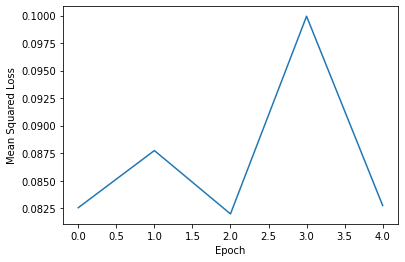

Run jqy9rscp errored: NameError("name 'back_pro' is not defined")
wandb: ERROR Run jqy9rscp errored: NameError("name 'back_pro' is not defined")
wandb: Agent Starting Run: 94dj8o99 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	hidden_layers: 4
wandb: 	init_method: xavier
wandb: 	learning_rate: 0.001
wandb: 	opt_algo: adam
wandb: 	sizes: 128
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


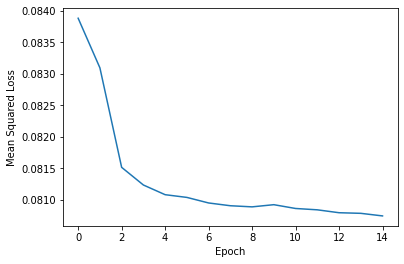

Run 94dj8o99 errored: NameError("name 'back_pro' is not defined")
wandb: ERROR Run 94dj8o99 errored: NameError("name 'back_pro' is not defined")
wandb: Agent Starting Run: o138l8xj with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 128
wandb: 	epochs: 15
wandb: 	hidden_layers: 4
wandb: 	init_method: random
wandb: 	learning_rate: 0.02
wandb: 	opt_algo: rmsprop
wandb: 	sizes: 64
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


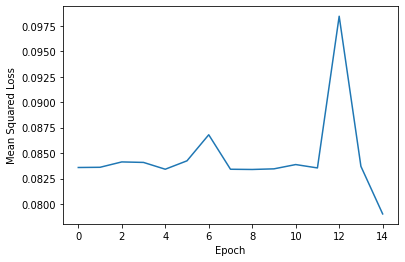

Run o138l8xj errored: NameError("name 'back_pro' is not defined")
wandb: ERROR Run o138l8xj errored: NameError("name 'back_pro' is not defined")
wandb: Agent Starting Run: zao3y5k2 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	hidden_layers: 5
wandb: 	init_method: xavier
wandb: 	learning_rate: 0.05
wandb: 	opt_algo: adam
wandb: 	sizes: 64
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


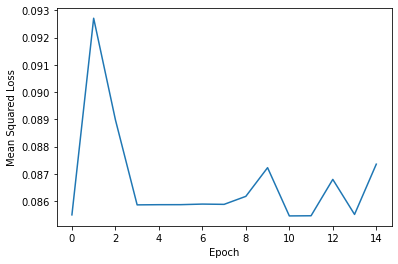

Run zao3y5k2 errored: NameError("name 'back_pro' is not defined")
wandb: ERROR Run zao3y5k2 errored: NameError("name 'back_pro' is not defined")
wandb: Agent Starting Run: ftn5sv1x with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	hidden_layers: 5
wandb: 	init_method: random
wandb: 	learning_rate: 0.0001
wandb: 	opt_algo: mgd
wandb: 	sizes: 128
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


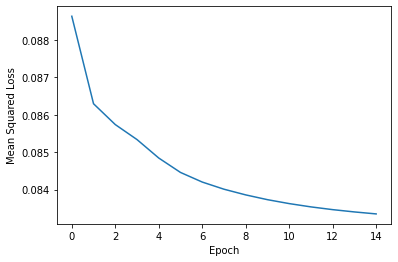

Run ftn5sv1x errored: NameError("name 'back_pro' is not defined")
wandb: ERROR Run ftn5sv1x errored: NameError("name 'back_pro' is not defined")
wandb: Agent Starting Run: rcbre0qt with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	init_method: random
wandb: 	learning_rate: 0.02
wandb: 	opt_algo: mgd
wandb: 	sizes: 64
wandb: 	weight_decay: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


In [ ]:
wandb.agent(sweep_id,function=train)